# Bootstrap multiple comparisons tutorial (WSC18)

This Jupyter _Python 3_ notebook has been written to accompany the WSC18 paper:

**PRACTICAL CONSIDERATIONS IN SELECTING THE BEST SET OF SIMULATED SYSTEMS**  _by Christine Currie and Tom Monks_.

The notebook provides a worked example of using BootComp to conduct a 2 stage screening and search of a simulation model.  

## 1. Preamble

### 1.1. Detail of the simulation model

The simulation model was used in a 2017 project in the UK to help a hospital, a community healthcare provider and a clinical commissioning group design and plan a new community rehabilitation ward.  In the UK, patients who require rehabilitation are often stuck in a queuing system where there must wait (inappropriately) in a acute hospital bed for a space in the rehabilitaiton ward.  The model investigated the sizing of the new ward in order to minimise patient waiting time whilst meeting probabilitic constraints regarding ward occupancy (bed utilization) and the number of transfers between single sex bays.

<img src="images/DToC.jpg" alt="Delayed Transfers of Care Model" title="Simulation Model and KPIs" />

### 1.2. Output data

The output data for the example analysis are bundled with git repository.  There are three .csv files in the data/ directory for 'waiting times', 'utilization' and 'transfers'.  

The model itself is not needed.  There are 50 replications of 1151 competing designs points.  Users can vary the number of replications used in the two stage procedure.  

The experimental design is also included for reference.

## 2. Prerequisites

### 2.1. BootComp Modules

In [1]:
import Bootstrap as bs
import BootIO as io
import ConvFuncs as cf

In [2]:
#DEV
import Bootstrap_crn as crn

### 2.2. Python Data Science Modules

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## 3. Procedure: Stage 1

** Optimization Parameters **

N_BOOTS = no. bootstraps to perform

** Stage 1 **

$n_1$ = no. stage 1 indeptendent replications for each systems / competing design

$p_1$ = percentage of bootstrap samples that must meet chance constraint in stage 1

$y_1$ proportion of bootstrap samples of primary KPI that must be within $x_1$ percent of the best system

** Stage 2 **

$n_2$ = no. stage 2 independent replications for each system / competigin design

$p_1$ = percentage of bootstrap samples that must meet chance constraint in stage 2

$y_1$ proportion of bootstrap samples of primary KPI that must be within $x_1$ percent of the best system in stage 2

In [4]:
N_BOOTS = 1000
n_1 = 5
n_2 = 45

gamma_1 = 0.7
x_1 = 0.1 
y_1 = 0.95

gamma_2 = 0.95
x_2 = 0.05
y_2 = 0.95


** Chance constraints **

In [5]:
min_util = 80 # ward occupancy >= 80%
max_tran = 50 # transfers between single sex bays <= 50

### Step 1: Read in initial $ n_1 $  replications

In [6]:

INPUT_DATA1 = "data/replications_wait_times.csv"
INPUT_DATA2 = "data/replications_util.csv"
INPUT_DATA3 = "data/replications_transfers.csv"
DESIGN = "data/doe.csv"

In [7]:
system_data_wait = crn.load_scenarios(INPUT_DATA1, exclude_reps = 50-n_1)
system_data_util = crn.load_scenarios(INPUT_DATA2, exclude_reps = 50-n_1)
system_data_tran = crn.load_scenarios(INPUT_DATA3, exclude_reps = 50-n_1)

N_SCENARIOS = system_data_wait.shape[1]
N_REPS = system_data_wait.shape[0]

print("Loaded waiting time data. {0} systems; {1} replications".format(system_data_wait.shape[1], system_data_wait.shape[0]))
print("Loaded utilzation data. {0} systems; {1} replications".format(system_data_util.shape[1], system_data_util.shape[0]))
print("Loaded transfers data. {0} systems; {1} replications".format(system_data_tran.shape[1], system_data_tran.shape[0]))

Loaded waiting time data. 1051 systems; 5 replications
Loaded utilzation data. 1051 systems; 5 replications
Loaded transfers data. 1051 systems; 5 replications


In [8]:
df_tran = pd.DataFrame(system_data_tran)
df_util = pd.DataFrame(system_data_util)
df_wait = pd.DataFrame(system_data_wait)

### Step 2: Limit to systems that satisfy chance constraints

Bootstrap function arguments

In [9]:
args =  bs.BootstrapArguments()

args.nboots = N_BOOTS
args.nscenarios = N_SCENARIOS
args.point_estimate_func = bs.bootstrap_mean


In [10]:
def bootstrap_chance_constraint(data, threshold, boot_args, gamma=0.95, kind='lower'):
    """
    Bootstrap a chance constraint for k systems and filter out systems 
    where p% of resamples are greater a threshold t.  
    
    Example 1. A lower limit.  If the chance constaint was related to utilization it could be stated as 
    filter out any systems where 95% of the distribution is greater than 80%.
    
    Example 2. An upper limit.  If the chance constraint related to unwanted ward transfers it could be stated 
    as filter out any systems where 95% of the distribution is less than 50 transfers per annum.
    
    Returns a pandas.Series containing of the feasible systems i.e. that do not violate the chance constraint.
    
    @data - a numpy array of the data to bootstrap
    @threshold - the threshold of the chance constraint
    @boot_args - the bootstrap setup class
    @p - the probability cut of for the chance constraint  (default p = 0.95)
    @kind - 'lower' = a lower limit threshold; 'upper' = an upper limit threshold (default = 'lower')
    
    """
    
    valid_operations = ['upper', 'lower']
    
    if kind.lower() not in valid_operations:
        raise ValueError('Parameter @kind must be either set to lower or upper')
    
    resample_list = bs.resample_all_scenarios(data.tolist(), boot_args)
    df_boots = cf.resamples_to_df(resample_list, boot_args.nboots)
    
    if('lower' == kind.lower()):
        
        df_counts = pd.DataFrame(df_boots[df_boots >= threshold].count(), columns = {'count'})
    else:
        df_counts = pd.DataFrame(df_boots[df_boots <= threshold].count(), columns = {'count'})
        
    df_counts['prop'] = df_counts['count'] / boot_args.nboots
    df_counts['pass'] = np.where(df_counts['prop'] >= gamma, 1, 0)
    df_counts.index -= 1
    
    return df_counts.loc[df_counts['pass'] == 1].index
    
    
    

#### Chance constraint 1:  Utilisation Threshold (value for money)

In [11]:
passed_1 = bootstrap_chance_constraint(data = system_data_util.T, threshold=min_util, boot_args=args, gamma=gamma_1)

In [12]:
passed_1

Int64Index([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,
            ...
            421, 422, 423, 424, 425, 426, 427, 428, 429, 430],
           dtype='int64', length=429)

#### Chance constraint 2: Upper bound on transfers between bays

In [13]:
passed_2 = bootstrap_chance_constraint(data = system_data_tran.T, threshold=max_tran, boot_args=args, 
                                       gamma=gamma_1, kind='upper')

In [14]:
passed_2

Int64Index([   0,    1,    2,   14,   35,   40,   50,   58,   62,   63,
            ...
            1041, 1042, 1043, 1044, 1045, 1046, 1047, 1048, 1049, 1050],
           dtype='int64', length=796)

#### Filter for systems that meet all chance constraints

In [15]:
subset = np.intersect1d(passed_1, passed_2)
subset

array([  0,   1,   2,  14,  35,  40,  50,  58,  62,  63,  64,  65,  66,
        67,  68,  79,  88,  89,  96, 101, 116, 119, 129, 130, 131, 132,
       133, 134, 135, 136, 147, 148, 149, 157, 158, 165, 166, 171, 184,
       187, 190, 198, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210,
       219, 220, 221, 222, 223, 229, 230, 231, 237, 238, 244, 249, 253,
       256, 259, 262, 270, 273, 274, 275, 276, 277, 278, 279, 280, 281,
       282, 283, 284, 285, 292, 293, 294, 295, 296, 301, 302, 303, 304,
       305, 306, 310, 311, 312, 313, 316, 317, 318, 322, 323, 326, 328,
       329, 330, 332, 333, 335, 343, 345, 346, 347, 348, 349, 350, 351,
       352, 353, 354, 355, 356, 357, 358, 359, 360, 365, 366, 367, 368,
       369, 370, 371, 372, 376, 377, 378, 379, 380, 381, 382, 385, 386,
       387, 388, 389, 391, 393, 394, 395, 398, 399, 400, 402, 403, 404,
       405, 406, 407, 408, 409, 410, 412, 413, 416, 418, 420, 421, 422,
       423, 424, 425, 426, 427, 428, 429, 430], dtype=int64)

In [16]:
subset.shape

(177,)

In [17]:

subset_waits = df_wait[subset].mean()
subset_waits.rename('wait', inplace=True)
subset_utils = df_util[subset].mean()
subset_utils.rename('util', inplace=True)
subset_tran = df_tran[subset].mean()
subset_tran.rename('tran', inplace=True)

0       0.2
1      28.2
2      37.4
14     36.0
35     32.2
40     41.2
50     23.8
58     41.2
62     35.2
63     15.4
64      8.8
65      2.0
66      0.0
67     26.0
68     40.2
79     26.0
88      0.0
89     33.6
96     42.0
101    31.8
116    30.2
119     0.0
129    37.0
130    21.4
131    10.8
132     3.0
133     0.0
134     0.0
135    23.2
136    35.4
       ... 
393    15.2
394    22.2
395    36.6
398    21.0
399    27.0
400    39.2
402     0.0
403    24.4
404    33.4
405    33.6
406    28.8
407    26.4
408    38.4
409    16.6
410    30.4
412     7.2
413    33.8
416    36.6
418    39.0
420    37.2
421    30.0
422    34.2
423     0.0
424    30.8
425    25.0
426    17.2
427     9.2
428     8.6
429     2.8
430     0.8
Name: tran, dtype: float64

List and rank the systems along with their peformance measures

In [18]:
subset_kpi = pd.concat([subset_waits, subset_utils, subset_tran], axis=1)

In [19]:
subset_kpi.sort_values(by=['wait', 'util', 'tran'])

,wait,util,tran
395,0.174890,80.812758,36.6
352,0.175423,80.812758,0.0
367,0.175423,80.812758,8.2
353,0.175423,80.812758,8.4
378,0.175423,80.812758,9.8
386,0.175423,80.812758,12.4
354,0.175423,80.812758,13.4
368,0.175423,80.812758,13.8
393,0.175423,80.812758,15.2
355,0.175423,80.812758,16.8


In [20]:
best_system_index = subset_kpi.sort_values(by=['wait', 'util', 'tran']).index[0]

In [21]:
best_system_index

395

### Step 3: setup differences

In [22]:
feasible_systems = df_wait[subset]

In [23]:
feasible_systems

,0,1,2,14,35,40,50,58,62,63,...,421,422,423,424,425,426,427,428,429,430
0,0.310817,0.310817,0.310817,0.310817,3.163141,3.144300,17.431210,3.144300,4.445242,10.594455,...,0.369838,0.025583,1.405745,0.050943,0.098968,0.187388,0.328097,0.684919,1.558797,4.087074
1,1.113904,1.113904,1.113904,1.113904,4.945780,4.023624,12.517940,4.023624,4.922641,8.298630,...,0.417195,0.211834,1.422116,0.259033,0.326558,0.457769,0.769874,1.332882,2.439476,4.410553
2,1.631624,1.631624,1.631624,1.631624,15.382675,4.701431,8.429396,4.701431,15.448503,23.046322,...,0.601702,0.341277,1.895106,0.474681,0.720426,1.193308,2.061588,4.027300,7.772688,14.958039
3,3.061275,3.061275,3.061275,3.061275,16.087584,6.952027,21.067490,6.952027,10.441470,15.879639,...,0.794301,0.678985,1.674533,0.844167,1.075758,1.525870,2.017188,2.785394,4.317652,10.066042
4,0.765249,0.765249,0.765249,0.765249,8.666150,2.161422,6.125000,2.161422,8.689823,13.705802,...,0.154639,0.075172,0.714347,0.131014,0.253222,0.495704,1.017612,2.496988,5.460331,8.356543


In [24]:
diffs =  pd.DataFrame(feasible_systems.as_matrix().T - np.array(feasible_systems[best_system_index])).T
diffs.columns = subset

### Step 4: Simple bootstrap of differences

In [25]:
resample_diffs = bs.resample_all_scenarios(diffs.values.T.tolist(), args)

In [26]:
df_boots_diffs= cf.resamples_to_df(resample_diffs, N_BOOTS)
df_boots_diffs.columns = subset
df_boots_diffs.shape

(1000, 177)

### Step 6: Rank systems  

In [27]:
indifference = feasible_systems[best_system_index].mean() * x_1
indifference

0.01748902732

In [28]:
#convert numbers to 0 or 1
# 1 = difference less than 0.244
# 0 = difference greater than 0.244

def indifferent(x, indifference):
    """
    
    """
    if x <= indifference:
        return 1
    else:
        return 0

In [29]:
df_indifference = df_boots_diffs.applymap(lambda x: indifferent(x, indifference))
df_indifference

,0,1,2,14,35,40,50,58,62,63,...,421,422,423,424,425,426,427,428,429,430
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Step 7: Define set $J$ where y% of bootstraps are within x% of the best mean

In [30]:
threshold = N_BOOTS * y_1
df_within_limit = df_indifference.sum(0)
df_within_limit= pd.DataFrame(df_within_limit, columns=['sum'])
take_forward = df_within_limit.loc[df_within_limit['sum'] >= threshold].index

In [31]:
take_forward

Int64Index([352, 353, 354, 355, 356, 357, 358, 359, 367, 368, 369, 370, 371,
            372, 378, 379, 380, 381, 382, 386, 387, 388, 389, 393, 394, 395,
            398, 399, 403, 404, 407, 408, 410, 413],
           dtype='int64')

In [32]:
no_stage1 = take_forward.shape[0]

_Quick look at stage 1 results_

In [33]:

df_doe = pd.read_csv(DESIGN, index_col='System')
df_doe.index -= 1
subset_kpi=  subset_kpi[subset_kpi.index.isin(take_forward)]
temp = df_doe[df_doe.index.isin(take_forward)]
df_stage1 = pd.concat([temp, subset_kpi], axis=1)
df_stage1.sort_values(by=['wait', 'util', 'tran'])

,Total beds,Size of Bays,Number of Bays,Number of Singles,wait,util,tran
System,,,,,,,
395,48,7,4,20,0.174890,80.812758,36.6
352,48,0,0,48,0.175423,80.812758,0.0
367,48,4,2,40,0.175423,80.812758,8.2
353,48,3,3,39,0.175423,80.812758,8.4
378,48,5,2,38,0.175423,80.812758,9.8
386,48,6,2,36,0.175423,80.812758,12.4
354,48,3,4,36,0.175423,80.812758,13.4
368,48,4,3,36,0.175423,80.812758,13.8
393,48,7,2,34,0.175423,80.812758,15.2


## 4. Procedure - Stage 2

### Step 8: More replicates of promicing solutions using Common Random Numbers

User simulates $ n_2 $ additional replicates for the feasible solutions brought forward from stage 1.

Example = 50 replicates (45 extra)

In [34]:
df_wait_s2 = pd.DataFrame(crn.load_scenarios(INPUT_DATA1))[take_forward]
df_util_s2 = pd.DataFrame(crn.load_scenarios(INPUT_DATA2))[take_forward]
df_tran_s2 = pd.DataFrame(crn.load_scenarios(INPUT_DATA3))[take_forward]

N_SCENARIOS = df_wait_s2.shape[1]
N_REPS = df_wait_s2.shape[0]

print("Loaded waiting time data. {0} systems; {1} replications".format(df_wait_s2.shape[1], df_wait_s2.shape[0]))
print("Loaded utilzation data. {0} systems; {1} replications".format(df_util_s2.shape[1], df_util_s2.shape[0]))
print("Loaded transfers data. {0} systems; {1} replications".format(df_tran_s2.shape[1], df_tran_s2.shape[0]))

Loaded waiting time data. 34 systems; 50 replications
Loaded utilzation data. 34 systems; 50 replications
Loaded transfers data. 34 systems; 50 replications


### Step 9: Repeat steps 2 - 6 from stage 1

#### Step 2 - Chance contraints

In [35]:
passed_1 = bootstrap_chance_constraint(data = df_util_s2.values.T, threshold=min_util, boot_args=args, gamma=gamma_2)

In [36]:
passed_1

Int64Index([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
            17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32,
            33],
           dtype='int64')

In [37]:
take_forward

Int64Index([352, 353, 354, 355, 356, 357, 358, 359, 367, 368, 369, 370, 371,
            372, 378, 379, 380, 381, 382, 386, 387, 388, 389, 393, 394, 395,
            398, 399, 403, 404, 407, 408, 410, 413],
           dtype='int64')

In [38]:
cc_1 = np.array([take_forward[x] for x in passed_1])
cc_1

array([352, 353, 354, 355, 356, 357, 358, 359, 367, 368, 369, 370, 371,
       372, 378, 379, 380, 381, 382, 386, 387, 388, 389, 393, 394, 395,
       398, 399, 403, 404, 407, 408, 410, 413], dtype=int64)

In [39]:
cc_1.shape

(34,)

In [40]:
passed_2 = bootstrap_chance_constraint(data = df_tran_s2.values.T, threshold=max_tran, boot_args=args, gamma=gamma_2, kind='upper')

In [41]:
passed_2

Int64Index([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
            17, 19, 20, 21, 23, 24, 25, 26, 27, 28, 29, 30, 32, 33],
           dtype='int64')

In [42]:
cc_2 = np.array([take_forward[x] for x in passed_2])
cc_2

array([352, 353, 354, 355, 356, 357, 358, 359, 367, 368, 369, 370, 371,
       372, 378, 379, 380, 381, 386, 387, 388, 393, 394, 395, 398, 399,
       403, 404, 407, 410, 413], dtype=int64)

In [43]:
cc_2.shape

(31,)

In [44]:
subset = np.intersect1d(cc_1, cc_2)
subset

array([352, 353, 354, 355, 356, 357, 358, 359, 367, 368, 369, 370, 371,
       372, 378, 379, 380, 381, 386, 387, 388, 393, 394, 395, 398, 399,
       403, 404, 407, 410, 413], dtype=int64)

In [45]:
subset.shape

(31,)

In [46]:
def get_subset_kpi(subset):
    subset_waits = df_wait_s2[subset].mean()
    subset_waits.rename('wait', inplace=True)
    subset_utils = df_util_s2[subset].mean()
    subset_utils.rename('util', inplace=True)
    subset_tran = df_tran_s2[subset].mean()
    subset_tran.rename('tran', inplace=True)
    
    subset_kpi = pd.concat([subset_waits, subset_utils, subset_tran], axis=1)
    subset_kpi.index.rename('System', inplace=True)
    
    return subset_kpi

In [47]:

subset_waits = df_wait_s2[subset].mean()
subset_waits.rename('wait', inplace=True)
subset_utils = df_util_s2[subset].mean()
subset_utils.rename('util', inplace=True)
subset_tran = df_tran_s2[subset].mean()
subset_tran.rename('tran', inplace=True)

352     0.00
353    12.72
354    16.54
355    20.86
356    25.40
357    29.94
358    35.30
359    40.22
367    12.46
368    17.32
369    22.70
370    28.84
371    35.72
372    42.28
378    15.88
379    21.82
380    29.68
381    37.70
386    19.18
387    26.18
388    36.02
393    22.50
394    31.02
395    41.46
398    26.16
399    35.80
403    29.46
404    39.48
407    33.18
410    36.22
413    39.48
Name: tran, dtype: float64

In [48]:
subset_kpi = pd.concat([subset_waits, subset_utils, subset_tran], axis=1)
subset_kpi.index.rename('System', inplace=True)

In [49]:
subset_kpi.sort_values(by=['wait', 'util', 'tran'])


,wait,util,tran
System,,,
403,0.203996,81.010689,29.46
369,0.204240,81.011203,22.70
398,0.204240,81.011775,26.16
352,0.204245,81.011717,0.00
367,0.204245,81.011717,12.46
353,0.204245,81.011717,12.72
378,0.204245,81.011717,15.88
354,0.204245,81.011717,16.54
368,0.204245,81.011717,17.32


In [50]:
best_system_index = subset_kpi.sort_values(by=['wait', 'util', 'tran']).index[0]

In [51]:
best_system_index

403

### Step [?]  Setup differences from best (stage 2)

In [52]:
feasible_systems = df_wait_s2[subset]
diffs =  pd.DataFrame(feasible_systems.as_matrix().T - np.array(feasible_systems[best_system_index])).T
diffs.columns = subset

### Bootstrap differences

In [53]:
resample_diffs = bs.resample_all_scenarios(diffs.values.T.tolist(), args)


In [54]:
df_boots_diffs= cf.resamples_to_df(resample_diffs, args.nboots)
df_boots_diffs.columns = subset
df_boots_diffs.shape

(1000, 31)

In [55]:
indifference = feasible_systems[best_system_index].mean() * x_2
indifference

0.010199813040000004

In [56]:
df_indifference = df_boots_diffs.applymap(lambda x: indifferent(x, indifference))
df_indifference

,352,353,354,355,356,357,358,359,367,368,...,393,394,395,398,399,403,404,407,410,413
1,1,1,1,1,1,1,1,1,1,1,...,1,1,0,1,0,1,1,1,1,1
2,1,1,1,1,1,1,1,1,1,1,...,1,1,0,1,1,1,0,1,1,1
3,1,1,1,1,1,1,1,1,1,1,...,1,1,0,1,1,1,0,1,1,1
4,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,0,1,1,1
5,1,1,1,1,1,1,1,1,1,1,...,1,1,0,1,1,1,0,1,1,1
6,1,1,1,1,1,1,1,1,1,1,...,1,1,0,1,1,1,0,1,1,1
7,1,1,1,1,1,1,1,1,1,1,...,1,1,0,1,0,1,0,1,1,1
8,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,0,1,1,1
9,1,1,1,1,1,1,1,1,1,1,...,1,1,0,1,1,1,0,1,1,1
10,1,1,1,1,1,1,1,1,1,1,...,1,1,0,1,1,1,0,1,1,1


In [57]:
threshold = args.nboots * y_2
df_within_limit = df_indifference.sum(0)
df_within_limit= pd.DataFrame(df_within_limit, columns=['sum'])
final_set = df_within_limit.loc[df_within_limit['sum'] >= threshold].index

In [58]:
final_set

Int64Index([352, 353, 354, 355, 356, 357, 358, 359, 367, 368, 369, 370, 371,
            372, 378, 379, 380, 381, 386, 387, 388, 393, 394, 398, 403, 407,
            410, 413],
           dtype='int64')

Final set of feasible systems selected from the competing designs

In [59]:
df_doe = pd.read_csv(DESIGN, index_col='System')
df_doe.index -= 1
#subtract 1 from index so taht it matches zero indexing in analysis.



In [60]:
subset_kpi = get_subset_kpi(final_set)
subset_kpi

,wait,util,tran
System,,,
352,0.204245,81.011717,0.00
353,0.204245,81.011717,12.72
354,0.204245,81.011717,16.54
355,0.204245,81.011717,20.86
356,0.204294,81.011717,25.40
357,0.204609,81.012289,29.94
358,0.205050,81.014004,35.30
359,0.206137,81.012289,40.22
367,0.204245,81.011717,12.46


In [61]:
temp = df_doe[df_doe.index.isin(final_set)]
#subset_kpi = subset_kpi.applymap(lambda x: '%.4f' % x)
df_final = pd.concat([temp, subset_kpi], axis=1)
df_final.sort_values(by=['wait', 'util', 'tran'])


,Total beds,Size of Bays,Number of Bays,Number of Singles,wait,util,tran
System,,,,,,,
403,48,9,2,30,0.203996,81.010689,29.46
369,48,4,4,32,0.204240,81.011203,22.70
398,48,8,2,32,0.204240,81.011775,26.16
352,48,0,0,48,0.204245,81.011717,0.00
367,48,4,2,40,0.204245,81.011717,12.46
353,48,3,3,39,0.204245,81.011717,12.72
378,48,5,2,38,0.204245,81.011717,15.88
354,48,3,4,36,0.204245,81.011717,16.54
368,48,4,3,36,0.204245,81.011717,17.32


In [62]:
print('No. in final set {0}'.format(df_final.shape[0]))

No. in final set 28


In [63]:
print('No. taken forward from stage 1: {0}'.format(no_stage1))

No. taken forward from stage 1: 34


In [64]:
df_final.to_clipboard(excel=True)

## Charts for paper

In [65]:
df_doe = pd.read_csv(DESIGN, index_col='System')
df_doe.index -= 1

Utilisation

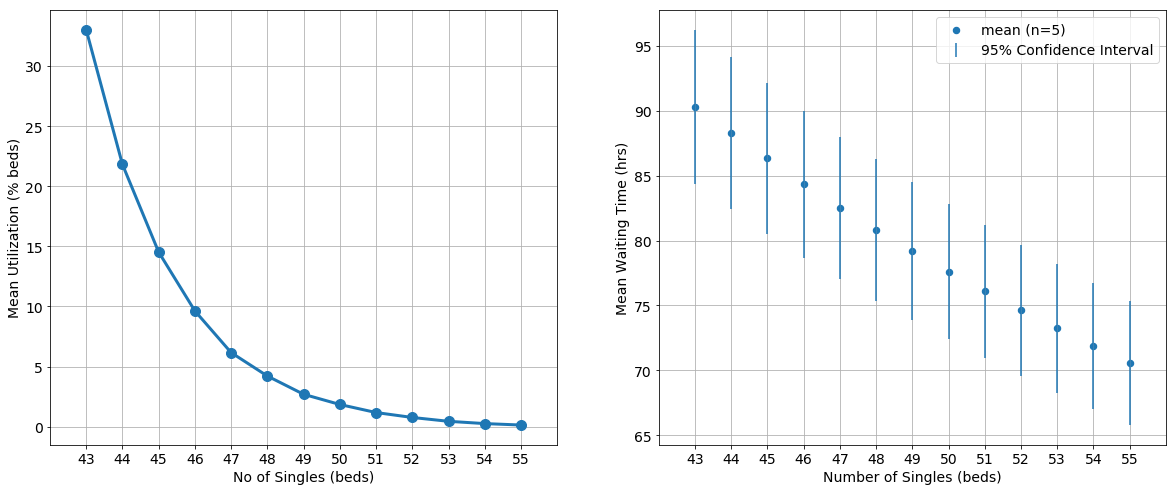

In [66]:
temp = df_doe.loc[df_doe['Number of Bays']==0]
#temp.index += 1
subset_waits = df_wait[temp.index].mean()
subset_waits.rename('wait', inplace=True)
subset_utils = df_util[temp.index].mean()
subset_utils.rename('util', inplace=True)
subset_trans = df_tran[temp.index].mean()
subset_trans.rename('tran', inplace=True)



subset_utils_sem = df_util[temp.index].sem()
subset_utils_sem.rename('util_sem', inplace=True)

subset_utils_count = df_util[temp.index].count()
subset_utils_count.rename('n_util', inplace=True)

import scipy as sp
import scipy.stats

subset_kpi = pd.concat([temp, subset_waits, subset_utils, subset_trans, subset_utils_sem, subset_utils_count], axis = 1)
subset_kpi['Waiting Time (hrs)'] = round(subset_kpi['wait']*24, 2)

confidence = 0.95

subset_kpi['hw_95'] = subset_kpi['util_sem'] * sp.stats.t.ppf((1+confidence)/2., subset_kpi['n_util']-1)

#fig = plt.figure()
#ax = fig.add_subplot(111)
fig, axes = plt.subplots(nrows=1, ncols=2, sharey=False)

subset_kpi.sort_values('util').plot(y = 'util', x= 'Number of Singles', figsize=(20, 8), fontsize = 14, 
                                    linewidth=3, legend =False, kind='scatter', ax=axes[1], xticks=[x for x in range(43, 56, 1)], xlim=(42, 56), yerr='hw_95')#, xlim=(70, 92), ylim=(0, 35))
axes[1].set_ylabel('Mean Waiting Time (hrs)', fontsize = 14)
axes[1].set_xlabel('Number of Singles (beds)', fontsize = 14)




subset_kpi.plot('Number of Singles', 'Waiting Time (hrs)', figsize=(20, 8), fontsize = 14, 
                                    linewidth=3, legend =False, kind='line', ms=10, style='o-', ax=axes[0], xlim=(42, 56),
                                    xticks=[x for x in range(43, 56, 1)])
axes[0].set_xlabel('No of Singles (beds)', fontsize = 14)
axes[0].set_ylabel('Mean Utilization (% beds)', fontsize = 14)
axes[0].grid(True)
axes[1].grid(True)
axes[1].legend(['mean (n=5)','95% Confidence Interval'],fontsize=14)
#plt.tight_layout()

In [67]:
fig.savefig("chance_constraint_stage1.pdf", format = 'pdf', dpi=300, bbox_inches='tight')

In [68]:
subset_kpi

,Total beds,Size of Bays,Number of Bays,Number of Singles,wait,util,tran,util_sem,n_util,Waiting Time (hrs),hw_95
System,,,,,,,,,,,
0,43,0,0,43,1.376574,90.309120,0.2,2.133189,5,33.04,5.922683
66,44,0,0,44,0.909685,88.289688,0.0,2.112451,5,21.83,5.865104
134,45,0,0,45,0.605550,86.315501,0.0,2.084790,5,14.53,5.788305
206,46,0,0,46,0.401065,84.331723,0.0,2.036425,5,9.63,5.654023
279,47,0,0,47,0.256866,82.502992,0.0,1.977089,5,6.16,5.489280
352,48,0,0,48,0.175423,80.812758,0.0,1.955978,5,4.21,5.430665
432,49,0,0,49,0.112213,79.174713,0.0,1.909494,5,2.69,5.301605
513,50,0,0,50,0.076849,77.602194,0.0,1.876105,5,1.84,5.208902
597,51,0,0,51,0.048801,76.085963,0.0,1.846766,5,1.17,5.127445


Patient transfers between bays of beds

In [69]:
temp=df_doe.loc[df_doe['Total beds']<=54]
#temp.index += 1
subset_waits = df_wait[temp.index].mean()
subset_waits.rename('wait', inplace=True)
subset_utils = df_tran[temp.index].mean()
subset_utils.rename('tran', inplace=True)

subset_kpi = pd.concat([temp, subset_waits, subset_utils], axis = 1)
subset_kpi['Waiting Time (hrs)'] = round(subset_kpi['wait']*24, 2)

subset_kpi.head()

,Total beds,Size of Bays,Number of Bays,Number of Singles,wait,tran,Waiting Time (hrs)
System,,,,,,,
0,43,0,0,43,1.376574,0.2,33.04
1,43,3,2,37,1.376574,28.2,33.04
2,43,3,3,34,1.376574,37.4,33.04
3,43,3,4,31,1.376574,56.4,33.04
4,43,3,5,28,1.376574,77.2,33.04


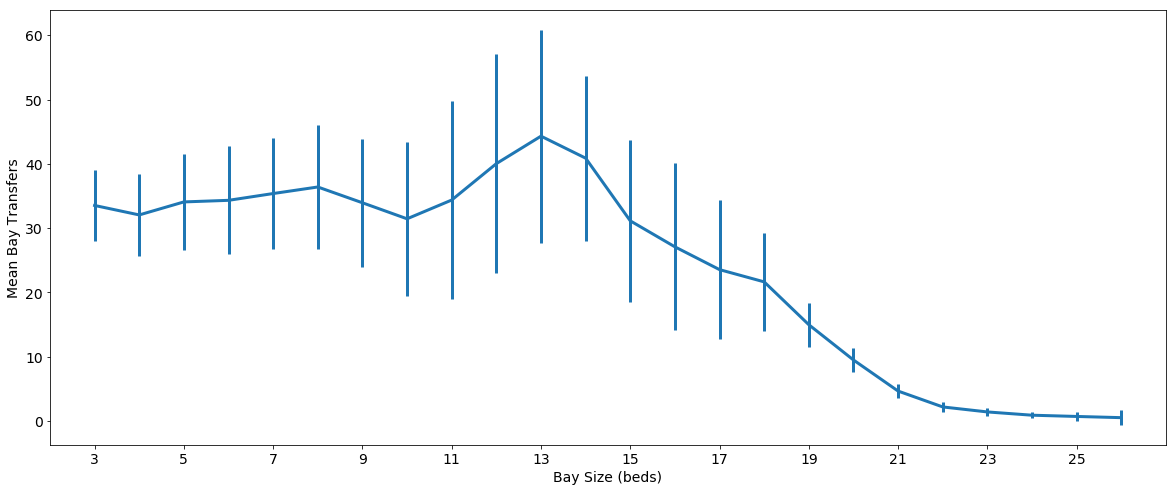

In [70]:
import scipy as sp
import scipy.stats

means = subset_kpi.groupby(['Size of Bays'])['tran'].mean()
means.rename('mean', inplace=True)
sems = subset_kpi.groupby(['Size of Bays'])['tran'].sem()
sems.rename('sem', inplace=True)
counts = subset_kpi.groupby(['Size of Bays'])['tran'].count()
counts.rename('n', inplace=True)




transfers = pd.concat([means, sems, counts], axis=1)
confidence = 0.95

transfers['hw_95'] = transfers['sem'] * sp.stats.t.ppf((1+confidence)/2., transfers['n']-1)

#fig = plt.figure()
#ax = fig.add_subplot(111)
fig, axes = plt.subplots(nrows=1, ncols=1)
transfers = transfers.loc[transfers.index >0]
transfers = transfers.loc[transfers.index <27]
transfers.plot(y='mean', x=transfers.index, figsize=(20, 8), fontsize = 14, 
                              linewidth=3, legend =False, kind='line', ax=axes, yerr='hw_95'
              , xlim=(2, 27), xticks=[x for x in range(3, 26, 2)])

axes.set_xlabel('Bay Size (beds)', fontsize = 14)

axes.set_ylabel('Mean Bay Transfers', fontsize = 14)

In [71]:
transfers

,mean,sem,n,hw_95
Size of Bays,,,,
3,33.528144,2.811370,167,5.550650
4,32.055814,3.200654,129,6.333041
5,34.078788,3.753690,99,7.449076
6,34.325000,4.223236,80,8.406142
7,35.381818,4.339494,66,8.666569
8,36.400000,4.815519,55,9.654535
9,33.944681,4.964878,47,9.993782
10,31.453659,5.906937,41,11.938365
11,34.371429,7.607410,35,15.460117
